# Explore then Commit (ETC)

In this excercises, we will be playing with the Multi-arm bandit problem with Explore then Commit algorithm.

## Setup

Consider unstructural bandit problem. Suppose we have $k$ arms, each with random rewards $p_i = u_i + \epsilon$ where $\epsilon$ is draw from i.i.d. standard gaussian. (Note that we only require $\epsilon$ to be sub-gaussian for the analysis to go through)

The following codes is capturing the setup.

In [ ]:
from typing import List
import numpy as np
# import pdb
import matplotlib.pyplot as plt
import time

In [ ]:
class Gaussian_Arm:
  def __init__(self, num_arms:int, mu:List[float]=None):
    """
    num_arms: (int). the number of arms
    mu: (None or list-type). the mean of the reward of each arm.
        if set to None, a random vector will be generated.
    """
    if num_arms <= 1 or not isinstance(num_arms, int):
      print('number of arms has an int that is at least two')
      return
    
    self.num_arms = num_arms
    #
    if mu:
      self.mu = np.asarray(mu)
      if len(self.mu) != num_arms:
        print('The lenth of mu does not match the number of arms')
        return
    else:
      self.mu = np.random.rand(num_arms)
    # 
    self.delta = max(self.mu) - min(self.mu)
    #

    # keep track of the rewards for the user
    self.rewards_history = []
    # keep track of how many times the arms have been pulled
    self.total_pull = 0 

  def pull_arm(self, arm_id:int =-1, pull_time:int =1) -> float:
    if arm_id < 0 or arm_id >= self.num_arms:
      print('please specify arm id in the range of 0-%d' % self.num_arms)
      return -1
    assert (isinstance(pull_time, int) and pull_time >= 1)
    self.total_pull += pull_time
    # Generate reward
    reward = self.mu[arm_id] * pull_time + sum(np.random.randn(pull_time))
    self.rewards_history.append(reward)
    return reward

  def genie_reward(self):
    """
    the best expected reward after pulling self.total_pull times
    """
    best_mu = max(self.mu)
    return self.total_pull * best_mu

  def my_rewards(self):
    return sum(self.rewards_history)

  def clear_reward_hist(self):
    self.rewards_history = []
    self.total_pull = 0


## Algorithm review

(Please refer to the lecture notes and the text book for details)

The parameter to set: the exploration time m\*k

1. Play each arm in the round-robin fashion until each arm are played m times
2. Compute the empirical reward estimation for each arm
3. Play the best arm (according to the empirical reward estimation) until the end of the game

## Goal of these exercises

Implement the following:

1. Basic ETC algorithm implementation
2. Plot the expected regret of ETC VS horizon ($n$).
3. The doubling trick.
4. Plot the expected regret of ETC with doubling trick VS horizon ($n$).

Answer the following:

1. What are the pros and cons of the doubling trick?
2. Does the regret VS horizon plot looks like $\log n$?
3. What if the exploration time is not set appropriately  (which means, we explore too little or too much) (Usually because the sub-optimality gap cannot be estimated appropriately)?
4. (Open-ended) Can we improve ETC?

## Tips:
1. The regret is expected to be logarithmic against the horizon. To check if the relationship is logarithmic, one can use the semilogx function in matplotlib.pyplot
2. When the regret is not logarithmic, please check against the analysis, and obtain insights there for debugging.
3. To see a smooth curve, one would have to repeat the simulation for multiple time, and take the empirical mean of the regret. This may be slow, if implemented on a single process. So please try-out parallel implementation, if you are comfortable with it (the simulation is very parallelable).


In [ ]:
# Setup
np.random.seed(2021)
num_trials = 10000
num_arms = 2
reward_probs = -np.sort(-np.random.uniform(0,1,num_arms))
horizons = np.linspace(100, 20000, 50).astype(np.int)
# horizons = np.logspace(1, 5, 91).astype(np.int)
bandit = Gaussian_Arm(num_arms, reward_probs.tolist())
# calculate suboptimality gap
delta = reward_probs[0] - reward_probs[1]

In [ ]:
def etc(bandit, delta, n, n_max):
    # print('n: %d | n_max: %d' % (n, n_max))
    num_arms = bandit.num_arms
    times_arms_pulled = np.zeros((num_arms, ))
    bandit.clear_reward_hist()
    arm_scores = np.zeros((num_arms, ))
    m = int(np.maximum(1, np.ceil(4/delta**2 * np.log(n * delta**2 / 4)))) # Calculate m for each n
    if n_max > num_arms * m:
        for k in range(num_arms):
            arm_scores[k] = bandit.pull_arm(k, m)
        times_arms_pulled[:] = m
        remaining_pulls = int(n - m*num_arms)
        if n_max < n:
            remaining_pulls = int(n_max - m*num_arms)
        if remaining_pulls > 0:
            best_arm = int(np.argmax(arm_scores))
            bandit.pull_arm(best_arm, remaining_pulls)
            times_arms_pulled[best_arm] += remaining_pulls
    else:
        all = int(n_max // num_arms)
        remainder = int(n_max % num_arms)
        # print('all: %d, remainder: %d' % (all, remainder))
        for k in range(num_arms):
            arm_scores[k] = bandit.pull_arm(k, all)
        times_arms_pulled[:] = all
        for k in range(remainder):
            arm_scores[k] += bandit.pull_arm(k, 1)
            times_arms_pulled[k] += 1
    # print(np.ceil(4/delta**2 * np.log(n * delta**2 / 4)))
    # print('m: %d | times pulled: %s' % (m, str(times_arms_pulled)))
    return times_arms_pulled

In [ ]:
## ETC

player_rewards = np.zeros((num_trials, len(horizons)))
optimal_reward = np.zeros(len(horizons))
times_arms_pulled = np.zeros((num_trials, num_arms, len(horizons)))

start_time = time.time()
for trial in range(num_trials):
    print('\r%3d/%3d | %5.2f s' % (trial, num_trials, time.time() - start_time), end='')
    for idx_n, n in enumerate(horizons):
        times_arms_pulled[trial, :, idx_n] = etc(bandit, delta, n, n)
print('\r%3d/%3d | %4.2f s' % (num_trials, num_trials, time.time() - start_time), end='')

10000/10000 | 680.90 s

In [ ]:
average_arms_pulled = np.mean(times_arms_pulled, 0)
regret = delta * average_arms_pulled[1,:]

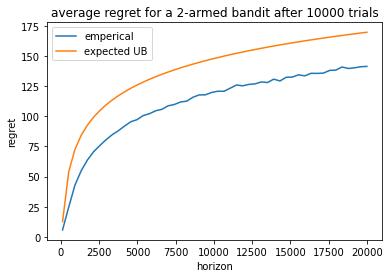

In [ ]:
expected = np.minimum(horizons * delta, delta + 4/delta * (1  + np.maximum(0, np.log(horizons * delta**2 / 4))))

plt.plot(horizons, regret, label='emperical')
# plt.semilogx(horizons, regret, label='emperical')
plt.plot(horizons, expected, label='expected UB')
plt.title('average regret for a %d-armed bandit after %d trials' % (num_arms, num_trials))
plt.ylabel('regret')
plt.xlabel('horizon')
plt.legend()
plt.show()

In [ ]:
## ETC w/ doubling trick

player_rewards = np.zeros((num_trials, len(horizons)))
optimal_reward = np.zeros(len(horizons))
times_arms_pulled = np.zeros((num_trials, num_arms, len(horizons)))

start_time = time.time()
for trial in range(num_trials):
    print('\r%3d/%3d | %5.2f s' % (trial, num_trials, time.time() - start_time), end='')
    for idx_n, n in enumerate(horizons):
        pulls_remaining = int(n)
        i = 1
        while pulls_remaining > 0:
            n_i = int(2**i)
            iteration_pulls = etc(bandit, delta, n_i, pulls_remaining)
            times_arms_pulled[trial, :, idx_n] += iteration_pulls
            i+=1
            pulls_remaining -= np.sum(iteration_pulls)
            assert pulls_remaining >= 0
print('\r%3d/%3d | %4.2f s' % (num_trials, num_trials, time.time() - start_time), end='')

10000/10000 | 851.35 s

In [ ]:
average_arms_pulled = np.mean(times_arms_pulled, 0)
regret = delta * average_arms_pulled[1,:]

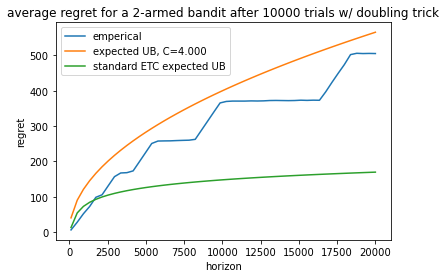

In [ ]:
plt.plot(horizons, regret, label='emperical')
# c = 0
# expected = c * np.log(horizons) + (4 / (delta * np.log(2)) * (np.log(horizons)**2))
# c = 2*(1+np.sqrt(2))
# expected = c * np.sqrt(horizons)
c = 4
expected = delta + c * np.sqrt(horizons)
plt.plot(horizons, expected, label='expected UB, C=%1.3f' % c)
expected = np.minimum(horizons * delta, delta + 4/delta * (1  + np.maximum(0, np.log(horizons * delta**2 / 4))))
plt.plot(horizons, expected, label='standard ETC expected UB')
plt.title('average regret for a %d-armed bandit after %d trials w/ doubling trick' % (num_arms, num_trials))
plt.ylabel('regret')
plt.xlabel('horizon')
plt.legend()
plt.show()

1. What are the pros and cons of the doubling trick?

An advantage of the doubling trick is that it does not rely on knowing the time horizon. This comes at the cost of a constant factor increase of regret, its most obvious disadvantage.
The algorithm still does require foreknowledge of the suboptimality gap which is likely not known.

2. Does the regret VS horizon plot looks like $\log n$?

With the standard ETC algorithm, yes. With the doubling trick, the shape more closely resembles a mix of $\log n$ and $\sqrt{n}$

3. What if the exploration time is not set appropriately (which means, we explore too little or too much) (Usually because the sub-optimality gap cannot be estimated appropriately)?

If the exploration time is too short then it is likely that a suboptimal choice is being commited to.
If the exploration time is too long then pulls will be wasted on suboptimal choices when an appropriate confidence level has been determined.
If m is fixed, regret grows linearly with n. This implies that even if the sub-optimality gap is known, stopping exploring when the time horizon is unknown is a poor strategy.

4. (Open-ended) Can we improve ETC?

With two arms of gaussian distributions, uniform sampling is an optimal exploration strategy.
For multiple arms, the exploration strategy could be different. When confidence that an arm is suboptimal is sufficiently large it could be dropped from the exploration pool.
Continually selecting the best arm is also optimal in the exploitation phase.
Other than better exploration strategies, it is difficult to see where ETC could be improved given the information it has access to and how close it is to the optimal solution.